# Example Notebook: Estimating Aquifer Time Constant

In this example we build a simple model of the Metolius river. This is a primarly groudwater dominated small watershed on the eastern side of the Cascades. We obtain streamflow data from:

https://apps.wrd.state.or.us/apps/sw/hydro_near_real_time/display_hydro_graph.aspx?station_nbr=14088500

for the period from Jan 1, 2010 to Jan 1, 2020. We also obtain rainfall data from PRISIM for the same interval. This approach works well here because in this area the soils are highly fractured due to volcanism and the vast majority of the water in the river is expected to be sourced from groundwater directly.



## Load And Plot Example Data

Sepecific discharge (in mm) and precipitation (also in mm) are located in 'BEE313 M5 L5.2 Example Data.csv'. This is 10 years of daily data.

We load these then rescale the precipitation as recharge ($RI$) such that the sum of $RI$ equals the sum of the streamflow. We do this because the subsurface area near the Metolius river is complex and the defined watershed area might not represent the actual contribuion area. Secondly, the PRISIM data was obtained for the location where the gauge is and not neccessarly reflective of the precip at higher (more easterly) sections of the watershed.


12401.164087628002 12401.164087628


Text(0, 0.5, 'Amount [mm]')

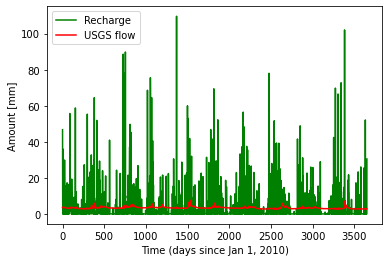

In [29]:
# Import numeric python and the plotting library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data and set as q, p, and t.
data = np.loadtxt('BEE313 M5 L5.2 Example Data.csv',delimiter=',',skiprows=1,usecols=(1,2)).astype(float)
qUSGS = data[:,0]; p = data[:,1]; time = np.arange(len(p))

# Rescale RI to match outflow
RI = p*np.sum(qUSGS)/np.sum(p)
print(np.sum(RI), np.sum(qUSGS))

plt.plot(time,RI,'g',label='Recharge')
plt.plot(time,qUSGS,'r',label='USGS flow')
plt.legend()
plt.xlabel('Time (days since Jan 1, 2010)'); 
plt.ylabel('Amount [mm]')


## A Linear Reservioir Model

Here we build a very simple linear reservoir model. The model has two parameters, $k_{T}$ and $h_{b}$. We build a simple defined function that takes in the value of the two constants. The flow out at time $i$ is given by 

$$ q_{Out}[i] = k_T (h[i] - h_b) $$

Then the updated storage at time $i$ is given by

$$ h[i] = h[i-1] + RI[i] - q_{Out}[i] $$

To run this model we need an inital time constant of $k_T$ in days. We recall that during periods without recharge ($RI$=0) and when the flow is decreasing, the slope of log[$q$] is an approximation for 1/$k_t$. So, to estimate this vaue we take the log of the flow and then calculate the difference between days. The slope is the change in the log flow divided by the change in days (here this is 1). Then we take the average of these difference values to estimate the residence time as a fist guess

In [30]:
# Calculate difference between log of flows
diff_list = np.diff(np.log(qUSGS),append=np.nan)

# Take average of days without rain where flow is decreasing and there is no rainfall
kRT_mean = np.nanmean(-diff_list[(diff_list<0)&(RI==0)])
print('Residence time is %.0f days (using the mean)' % (1/kRT_mean))


Residence time is 118 days (using the mean)


So, we will run this model with an inital time constant of $1/k_T$=118 days and a $h_b$ equal to zero. We set the inital storage at the total annual recharge (averaged over 10 years). This is just a simple first guess at these constants.

Text(0, 0.5, 'Amount [mm]')

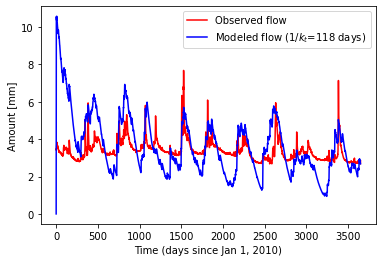

In [31]:
h0 = np.sum(RI)/10

# Model Flow
def modelFlow(kT,hb):
    # Empty place holders
    hOut = np.zeros((len(time))) + h0
    qOut = np.zeros((len(time)))
    # Step through each time point
    for i in time[1:]:
        qOut[i] = kT*(hOut[i-1] - hb)    
        hOut[i] = hOut[i-1] + RI[i] - qOut[i]
    # Return the model flow estimate
    return qOut
    
# Run the model
qModel = modelFlow(kRT_mean, 0)

# Compare plots
plt.plot(time,qUSGS,'r',label='Observed flow')
plt.plot(time,qModel,'b',label='Modeled flow ($1/k_t$=%.0f days)'%(1/kRT_mean))
plt.legend()
plt.xlabel('Time (days since Jan 1, 2010)'); 
plt.ylabel('Amount [mm]')

## Calculate Error Statistics

Given the model output and the observed flow we can calculate a few error statistics. For example the 'Root Mean Squared Error' (RMSE) can be caluclated as 

$$ RMSE = \sqrt{\sum{ (x_{obs} - x_{model})^2 }} $$

The larger the RMSE the worse your model is preforming.

Another common metric used to calculate the error of a hydrologic model is the 'Nash-Sutcliffe Efficiency' (NSE). This can be calculated as

$$ NSE = 1 - \frac{ \sum(x_{obs} - x_{model})^2 }{ \sum(x_{obs} - \overline{x_{obs}} )^2 } $$
        
where the overline denotes the average of the observations. A larger value of the NSE means your model is preforming better. The best possible value of the NSE is 1. A NSE value less than 1 means that your model is worse than just using a single mean value.



In [32]:
def RMSE(xObs,xModel):
    return np.sqrt( np.sum( (xObs-xModel)**2 ) )

def NSE(xObs,xModel):
    return 1 - (np.sum( (xObs-xModel)**2 )/np.sum( (xObs-np.mean(xObs))**2) )

print('The RMSE is', RMSE(qUSGS,qModel))
print('The NSE is', NSE(qUSGS,qModel))

The RMSE is 86.05774969790504
The NSE is -5.898593691752988


Note that the NSE above is less than zero. This suggestes we would be better off not even having a model. So lets make it better.

## Basic Calibration Approach

In this situation, we wish to find the best value of $k_T$. We do this by checking a set of different values of the parameters and calculating their fitness. 

Best model has NSE=0.364 at 1/kT = 480.00 days


Text(0, 0.5, 'NSE')

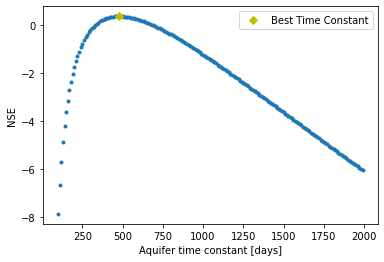

In [37]:
kList = 1/np.arange(100,2000,10)
NSEList = np.zeros(len(kList))

for i in np.arange(len(kList)):
    # Run the model
    qModel = modelFlow(kList[i], 0)
    # Evaluate the model
    nse = NSE(qUSGS,qModel)
    NSEList[i] = nse
    #print('The NSE is', nse)

bestModelIndex = np.argmax(NSEList)
bestNSE = NSEList[bestModelIndex]
bestTimeConstant = 1/kList[bestModelIndex]
print('Best model has NSE=%.3f at 1/kT = %.2f days' %(bestNSE, bestTimeConstant))
plt.plot(1/kList,NSEList,'.')
plt.plot(bestTimeConstant,bestNSE,'yD',label='Best Time Constant')
plt.legend()
plt.xlabel('Aquifer time constant [days]')
plt.ylabel('NSE')



## Run The Best Model

Now we run the model again, this time with our calibrated $k_T$ value. We note that now the model better matches the observed values.

Text(0, 0.5, 'Amount [mm]')

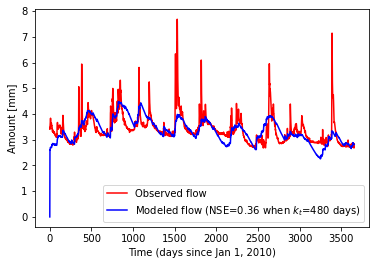

In [38]:
# Run the model
qModel = modelFlow(1/bestTimeConstant, 0)

# Compare plots
plt.plot(time,qUSGS,'r',label='Observed flow')
plt.plot(time,qModel,'b',label='Modeled flow (NSE=%.2f when $k_t$=%d days)'%(bestNSE,bestTimeConstant))
plt.legend()
plt.xlabel('Time (days since Jan 1, 2010)'); 
plt.ylabel('Amount [mm]')